**Este é um trabalho realizado por alunos da UFPR para a matéria de graduação de Machine Learning. A database utilizada foi a Telco Customer Churn, disponível em https://www.kaggle.com/datasets/blastchar/telco-customer-churn.**

**Nosso objetivo é criar um modelo de machine learning que consiga prever se um cliente irá ou não dar o Churn utilizando os dados fornecidos pela database.**

**Este é um trabalho realizado para fins de estudo, portanto, iremos comparar os resultados obtidos utilizando validação hold-out e o método de validação cruzada k-fold. Além disso, como será visto durante o código, um dos métodos utilizados para filtragem de variáveis foi a regressão lasso, com a qual fizemos um grid-search e também comparamos resultados para diferentes alphas.**

**Além disso, trouxemos também algumas reflexões e análises sobre regras de negócios, análise de variância, covariância e transformação de dados.**

**Tendo em vista a natureza do trabalho, nosso objetivo não é fazer um algoritmo estado de arte, mas analisar e comparar resultados, trazendo reflexões tanto para nós, autores, quanto para os futuros leitores.**

In [ ]:
import sklearn
import pandas  as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import cross_val_score


In [ ]:
files.upload()

{}

**LENDO O ARQUIVO CSV**

In [ ]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**NO PRIMEIRO COMANDO, ESTAMOS FAZENDO A CONTAGEM DE CAMPOS TOTAIS, CAMPOS NULOS E OBSERVANDO A TIPAGEM DE CADA FEATURE.**

**NO SEGUNDO, PODEMOS OBSERVAR, ALÉM DA CONTAGEM DOS CAMPOS, A MÉDIA, DESVIO PADRÃO, O MÍNIMO E O MÁXIMO DAS FEATURES NUMÉRICAS**

In [ ]:
## printa as informações do dataset. Nosso objetivo é saber o tipo das variáveis e verrificar se é necessária alguma alterção
dataset.info()

## printa a quantidade de linhas preenchidas, média, desvio padrão e menor valor
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


**Neste primeiro treino vamos fazer a validação hold-out, que consiste em dividir base de dados entre base de treino e base de validação. Nossa escolha de proporção foi de 80% dos dados para treinamento e 20% dos dados para validação.**

In [ ]:
base_treino = dataset.sample(frac=0.7,random_state=42) # Pegando 70% da base aleatóriamente para ser treino.
print(base_treino.shape)

index_fora_do_treino = dataset.index.difference(base_treino.index) # Pegando os indexes que não estão na base 

base_val = dataset.iloc[index_fora_do_treino]
print(base_val.shape)

(4930, 21)
(2113, 21)


Embora o primeiro treino seja feito utilizando validação hold-out, para fins de organização de código deixaremos aqui a função que define o método kfold, que será utilizado nos próximos treinamentos.

In [ ]:
def kfold(base, k = 5):
    '''Essa função retorna, de acordo com a base e o k, os indexes aleatórios para cada partição k.'''
    list_indexes = [] # Lista com os indexes para cada partição. 
    obs_in_each_partition = int(np.round(base.shape[0]/k)) # quantas observações em cada partição
    
    possible_indexes = base.index.values # lista de indexes da base possíveis
    for k_zin in range(1, k):
        new_list_index = np.random.choice(possible_indexes, obs_in_each_partition, replace = False) #escolhendo as obs para o k
        possible_indexes = set(possible_indexes) - set(new_list_index) #tirando as obs do k atual, da lista de indexes possíveis
        possible_indexes = list(possible_indexes) 
        list_indexes.append(new_list_index) # adicionando as obs do k atual, na lista com os indexes para cada partição.
    
    list_indexes.append(np.array(possible_indexes)) # adicionando as obs da última partição (normalmente com menor size)
    return list_indexes      

Voltando à manipulação dos dados com validação hold-out...

**Agora nós temos a base de treino com 4930 linha e a base de validação com 2113, totalizando os 7043 clientes únicos.**

Dividindo as features da resposta

In [ ]:
X_treino = base_treino.drop(columns='Churn')
Y_treino = base_treino['Churn']
X_val = base_val.drop(columns='Churn')
Y_val = base_val.Churn


**Agora, vamos tratar os dados de treino. Lembrando que tudo que for feito nos dados de treino, também deve ser feito nos dados de validação.**


# **DADOS DE TREINO**

**Primeiramente, analisaremos os dados de treino utilizando os comandos info e describe.**

In [ ]:
X_treino.info()
X_treino.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4930 entries, 185 to 4403
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4930 non-null   object 
 1   gender            4930 non-null   object 
 2   SeniorCitizen     4930 non-null   int64  
 3   Partner           4930 non-null   object 
 4   Dependents        4930 non-null   object 
 5   tenure            4930 non-null   int64  
 6   PhoneService      4930 non-null   object 
 7   MultipleLines     4930 non-null   object 
 8   InternetService   4930 non-null   object 
 9   OnlineSecurity    4930 non-null   object 
 10  OnlineBackup      4930 non-null   object 
 11  DeviceProtection  4930 non-null   object 
 12  TechSupport       4930 non-null   object 
 13  StreamingTV       4930 non-null   object 
 14  StreamingMovies   4930 non-null   object 
 15  Contract          4930 non-null   object 
 16  PaperlessBilling  4930 non-null   object

,SeniorCitizen,tenure,MonthlyCharges
count,4930.000000,4930.000000,4930.000000
mean,0.161866,32.200811,64.879138
std,0.368365,24.546044,29.933020
min,0.000000,0.000000,18.700000
25%,0.000000,9.000000,35.750000
50%,0.000000,29.000000,70.400000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


**Note que a feature "Total Charges" está tipada como objeto. Portanto, faremos uma conversão para float.**

In [ ]:
#Transforma a coluna TotalCharges em numérica, o parâmetro coerce força com que a transformação seja feita, ignorando os erros.
X_treino["TotalCharges"] = pd.to_numeric(X_treino.TotalCharges, errors='coerce')



**Tendo em vista que mudamos a tipagem da coluna TotalCharges de object para float utilizando o parâmetro "coerce", que força essa mudança, é interessante analisarmos novamente se esta coluna tem algum dado NaN (not a number), que poderá influenciar futuramente a nossa modelagem.**




In [ ]:
X_treino[X_treino.TotalCharges.isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN


Note que exatamente os mesmos clientes que estão com dados faltantes no campo TotalCharges são os únicos com tenure igual a zero.

In [ ]:
X_treino[X_treino.tenure == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN


**Encontramos seis clientes onde a feature "TotalCharges" está faltante. Note que o comando describe não captou estes dados. Isso se deve ao fato de termos strings com um espaço no campo, fazendo com que o describe entendesse aquilo como um campo preenchido. Mas quando trocamos para float e utilizamos o comando "coerce" os campos nulos são evidenciados**


**Para resolver o problema dos campos nulos, vamos fazer uma análise dos dados obtidos.**

**No banco de dados, nós temos três colunas que podem nos ajudar a entender estes dados faltantes. A coluna tenure, que é o período em que o cliente consome (ou consumiu) o nosso produto, em meses; a coluna monthly charges, que corresponde a conta mensal que deve ser paga pelo cliente pelo serviço e finalmente a coluna totalcharges, que corresponde ao montante total pago pelo cliente até o momento.**

**Portanto, podemos supor que a coluna totalcharges possa ser descrita da seguinte maneira:**



>>>TotalCharges = (MonthlyCharges) x (Tenure)

**Porém, em algumas linhas podemos ver sutis diferenças entre o valor de TotalCharges calculado desta maneira e o real. Porém, para o caso de Tenure igual a zero, ou seja, o cliente ainda não completou um mês, podemos entender que a primeira fatura ainda não foi cobrada e, portanto, TotalCharges é igual a zero neste momento. Exatamente o que acontece nas linhas com dados faltantes, todas elas tem tenure igual a zero. Portanto, podemos fazer esta interpretação dos dados**







In [ ]:
X_treino['TotalCharges'].replace(np.NaN, 0, inplace=True)
X_treino[X_treino.TotalCharges.isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


**Agora, sem dados faltantes, podemos continuar a nossa modelagem. O primeiro passo será remover a coluna de Id dos clientes para evitar dados vazados.**


In [ ]:
X_treino.head()
X_treino.drop('customerID', axis=1, inplace=True)

**Transformando os dados de classificação em numéricos:**

In [ ]:
for i in X_treino:
  
  if X_treino[i].dtypes=='object':
    print(f'{i}: {X_treino[i].unique()}' )

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'Yes' 'No']
InternetService: ['DSL' 'No' 'Fiber optic']
OnlineSecurity: ['No' 'No internet service' 'Yes']
OnlineBackup: ['No' 'No internet service' 'Yes']
DeviceProtection: ['No' 'No internet service' 'Yes']
TechSupport: ['No' 'No internet service' 'Yes']
StreamingTV: ['No' 'No internet service' 'Yes']
StreamingMovies: ['No' 'No internet service' 'Yes']
Contract: ['Month-to-month' 'Two year' 'One year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Bank transfer (automatic)' 'Mailed check'
 'Credit card (automatic)']


In [ ]:
X_treino.replace('No phone service', 'No', inplace=True)
X_treino.replace('No internet service', 'No', inplace=True)

In [ ]:
X_treino_num = X_treino.replace('No', 0)
X_treino_num.replace('Yes', 1, inplace=True)
X_treino_num['gender'].replace('Female', 0, inplace=True)
X_treino_num['gender'].replace('Male', 1, inplace=True)
X_treino_num.replace('DSL', 1, inplace=True)
X_treino_num.replace('Fiber optic', 2, inplace=True)
X_treino_num.replace('Month-to-month', 0, inplace=True)
X_treino_num.replace('Two year',  2, inplace=True)
X_treino_num.replace('One year', 1, inplace=True)
X_treino_num.replace('Electronic check', 0, inplace=True)
X_treino_num.replace('Bank transfer (automatic)', 1, inplace=True)
X_treino_num.replace('Mailed check', 2, inplace=True)
X_treino_num.replace('Credit card (automatic)', 3, inplace=True)

Agora podemos olhar para a correlação e variância das features

In [ ]:
X_treino_num.corr()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
gender,1.000000,0.002496,0.013232,0.016546,0.008228,-0.005278,-0.007923,-0.015303,-0.011116,-0.007023,0.008828,-0.006623,0.001168,-0.009286,0.004906,-0.005979,0.009911,-0.013798,0.003698
SeniorCitizen,0.002496,1.000000,0.015790,-0.208142,0.024272,0.003966,0.153753,0.255450,-0.043231,0.083694,0.054427,-0.063744,0.109885,0.109756,-0.139795,0.171019,-0.147277,0.217939,0.109545
Partner,0.013232,0.015790,1.000000,0.451960,0.380982,0.022479,0.147096,-0.010646,0.141114,0.135122,0.150726,0.107973,0.118394,0.117140,0.289740,-0.015057,0.058744,0.088767,0.317591
Dependents,0.016546,-0.208142,0.451960,1.000000,0.149110,0.006038,-0.025379,-0.178813,0.075509,0.003175,0.014690,0.057137,-0.015418,-0.037830,0.233708,-0.113733,0.111069,-0.114359,0.054649
tenure,0.008228,0.024272,0.380982,0.149110,1.000000,0.024115,0.334372,0.025120,0.331149,0.358670,0.357177,0.301967,0.272544,0.273490,0.668473,0.006193,0.171109,0.242203,0.827940
PhoneService,-0.005278,0.003966,0.022479,0.006038,0.024115,1.000000,0.281716,0.098619,-0.098766,-0.048305,-0.061707,-0.102235,-0.024177,-0.028517,0.013993,0.025025,0.002349,0.254674,0.122131
MultipleLines,-0.007923,0.153753,0.147096,-0.025379,0.334372,0.281716,1.000000,0.339471,0.099281,0.197424,0.196329,0.086933,0.256179,0.247671,0.104127,0.159781,-0.063180,0.486271,0.467005
InternetService,-0.015303,0.255450,-0.010646,-0.178813,0.025120,0.098619,0.339471,1.000000,0.151443,0.304250,0.309358,0.156212,0.426004,0.416542,-0.304246,0.377775,-0.309940,0.904415,0.421650
OnlineSecurity,-0.011116,-0.043231,0.141114,0.075509,0.331149,-0.098766,0.099281,0.151443,1.000000,0.284145,0.280097,0.357848,0.173439,0.176562,0.246453,-0.010188,0.102501,0.291305,0.413515
OnlineBackup,-0.007023,0.083694,0.135122,0.003175,0.358670,-0.048305,0.197424,0.304250,0.284145,1.000000,0.302580,0.278100,0.281563,0.257038,0.145790,0.126483,-0.008565,0.436909,0.507649


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
185,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,24.80,24.80,1
2715,1,0,0,0,41,1,1,0,0,0,0,0,0,0,0,1,1,25.25,996.45,0
3825,0,0,1,1,52,1,0,0,0,0,0,0,0,0,2,0,2,19.35,1031.70,0
1807,0,0,0,0,1,1,0,2,0,0,1,0,0,0,0,0,0,76.35,76.35,1
132,1,0,0,0,67,1,0,1,0,0,0,1,0,0,2,0,1,50.55,3260.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,1,0,0,0,7,1,0,1,0,0,0,0,0,0,0,1,1,44.65,322.50,0
891,1,0,1,1,50,1,1,2,0,1,1,0,1,1,0,1,1,103.85,5017.90,1
2793,1,0,0,0,4,1,1,2,1,0,0,0,0,0,0,1,0,80.10,336.15,0
5912,0,1,0,0,47,1,1,2,0,1,1,0,0,0,0,1,1,85.20,3969.35,1


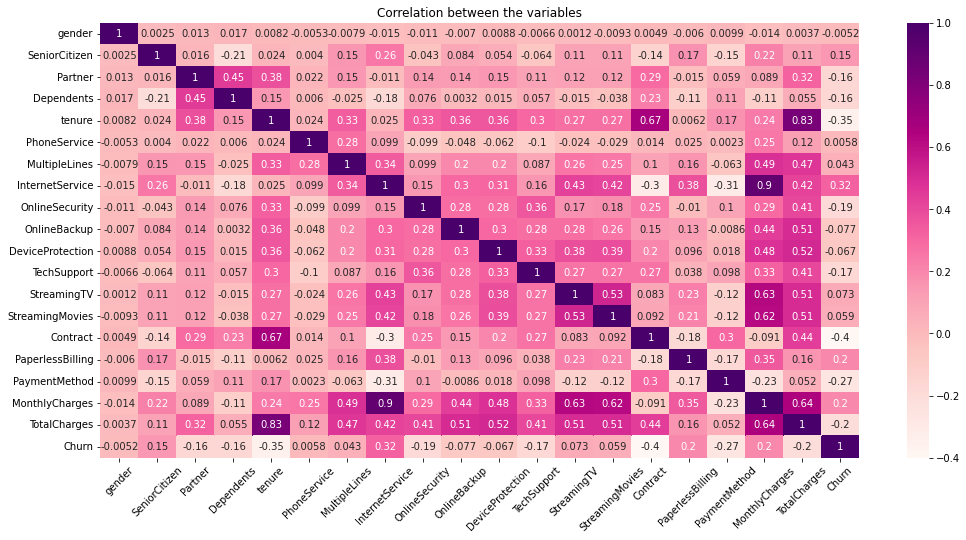

In [ ]:
plt.subplots(figsize=(17,8))

df_plot = X_treino_num

df_plot['Churn'] = np.where(Y_treino == 'No', 0, 1)
features_correlation=df_plot.corr()
sb.heatmap(features_correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)
df_plot

In [ ]:
NotSenior = X_treino_num[X_treino_num.SeniorCitizen == 0].SeniorCitizen.count()
IsSenior = X_treino_num[X_treino_num.SeniorCitizen == 1].SeniorCitizen.count()
NotSeniorPct = NotSenior/ (NotSenior + IsSenior)
print('NOT SENIOR CTITIZENS: ', NotSenior, '\n SENIOR CITIZENS : ',  IsSenior)
print('Porcentegem de NotSeniors: ', NotSeniorPct)


NOT SENIOR CTITIZENS:  4132 
 SENIOR CITIZENS :  798
Porcentegem de NotSeniors:  0.8381338742393509


In [ ]:
X_treino_num.drop(columns='Churn', inplace=True)
X_treino_num.var()

gender              2.500427e-01
SeniorCitizen       1.356930e-01
Partner             2.498491e-01
Dependents          2.111707e-01
tenure              6.025083e+02
PhoneService        8.936838e-02
MultipleLines       2.434663e-01
InternetService     6.023078e-01
OnlineSecurity      2.060525e-01
OnlineBackup        2.250778e-01
DeviceProtection    2.266550e-01
TechSupport         2.065616e-01
StreamingTV         2.370067e-01
StreamingMovies     2.364920e-01
Contract            6.931905e-01
PaperlessBilling    2.420836e-01
PaymentMethod       1.324142e+00
MonthlyCharges      8.959857e+02
TotalCharges        5.104174e+06
dtype: float64

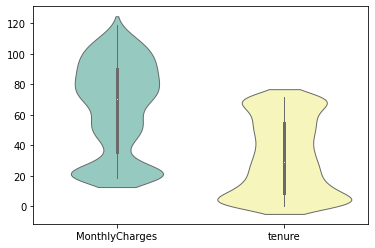

In [ ]:
sb.violinplot(data=X_treino_num[['MonthlyCharges', 'tenure']], palette="Set3", bw=.2, cut=1, linewidth=1)


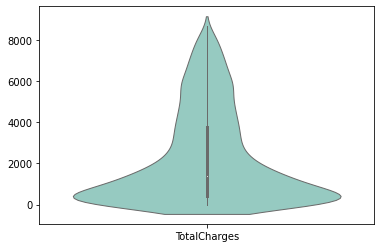

In [ ]:
sb.violinplot(data=X_treino_num[['TotalCharges']], palette="Set3", bw=.2, cut=1, linewidth=1)

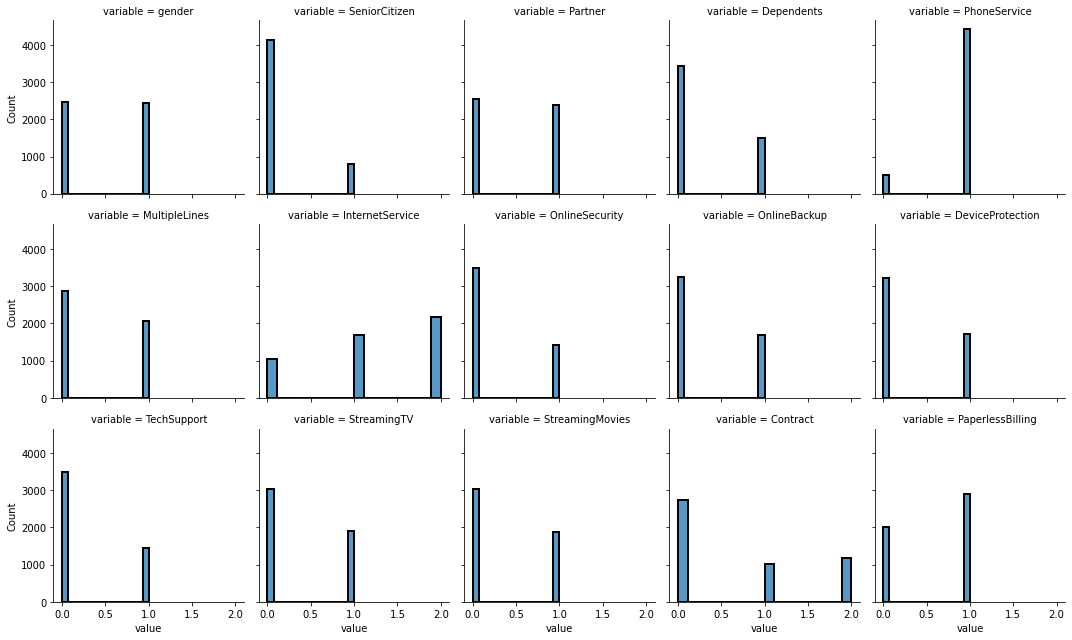

In [ ]:
plot_dataframe = X_treino_num.drop(columns=['TotalCharges', 'MonthlyCharges', 'tenure'])
df = pd.melt(plot_dataframe, plot_dataframe.columns[-1], plot_dataframe.columns[:-1])

g = sb.FacetGrid(df, col="variable", col_wrap=5)
g.map(sb.histplot, "value", linewidth=2)

**Normalizando os dados para evitar problemas de escala no modelo**

In [ ]:
def normalizar(lista):
    return (lista - np.min(lista))/(np.max(lista) - np.min(lista))

X_train_norm = X_treino_num.apply(lambda x: normalizar(x), axis = 0)
X_train_norm.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
185,0.0,0.0,1.0,0.0,0.013889,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.060970,0.002856
2715,1.0,0.0,0.0,0.0,0.569444,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.065467,0.114735
3825,0.0,0.0,1.0,1.0,0.722222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.006497,0.118794
1807,0.0,0.0,0.0,0.0,0.013889,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.576212,0.008791
132,1.0,0.0,0.0,0.0,0.930556,1.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.318341,0.375380


**O que falta fazer**
- testar os modelos e escolher o melhor
- aplicar k-fold e hould-out para comparar



In [ ]:
# preferência pessoal para observar os dados
# pd.set_option ('display.max_rows', None)
# base_treino_num

Ou seja, clientes no banco de dados, cerca de 19,3% são idosos. 

USANDO REGRESSÃO LASSO PARA FILTRAR AS VARIÁVEIS NORMALIZADAS

In [ ]:
from sklearn import linear_model
Y_treino.replace('Yes', 1, inplace=True)
Y_treino.replace('No', 0, inplace=True)
coef_matrix = []
search_space = {
    "alpha" : [0.00001, 0.00005, 0.0001,0.0005, 0.001,0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.15]
}
for i in range(len(search_space["alpha"])):
  clf = linear_model.Lasso(alpha=search_space["alpha"][i])
  clf.fit(X_train_norm, Y_treino)
  coef_matrix.append(clf.coef_)
  print(coef_matrix)


[array([ 0.00228054,  0.04633999, -0.01098967, -0.02239191, -0.11792928,
        0.01460001,  0.07388823,  0.48496634, -0.05222425, -0.00246698,
        0.00926439, -0.05899204,  0.08696788,  0.0664224 , -0.06756775,
        0.04937966, -0.08084482, -0.24543667, -0.43768234])]
[array([ 0.00228054,  0.04633999, -0.01098967, -0.02239191, -0.11792928,
        0.01460001,  0.07388823,  0.48496634, -0.05222425, -0.00246698,
        0.00926439, -0.05899204,  0.08696788,  0.0664224 , -0.06756775,
        0.04937966, -0.08084482, -0.24543667, -0.43768234]), array([ 0.00206089,  0.0460566 , -0.01078887, -0.02232869, -0.11796959,
       -0.03368408,  0.06116365,  0.36202972, -0.06441823, -0.01450476,
       -0.0028041 , -0.07129464,  0.06226509,  0.04180002, -0.0677922 ,
        0.04944238, -0.08074165, -0.        , -0.4368239 ])]
[array([ 0.00228054,  0.04633999, -0.01098967, -0.02239191, -0.11792928,
        0.01460001,  0.07388823,  0.48496634, -0.05222425, -0.00246698,
        0.00926439, -0

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e+01, tolerance: 9.707e-02
  model = cd_fast.enet_coordinate_descent(


Para entender melhor, vamos fazer um gráfico dessa matriz de coeficientes

In [ ]:
alpha_index = []
for i in range(len(search_space['alpha'])):
  alpha_index.append(f'alpha{i}')
alphas = pd.DataFrame(search_space['alpha'], index=alpha_index)

coef_dataframe = pd.DataFrame(coef_matrix, index=search_space['alpha'])


In [ ]:
coef_dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0.00001,0.002281,0.046340,-0.010990,-0.022392,-0.117929,0.014600,0.073888,0.484966,-0.052224,-0.002467,0.009264,-0.058992,0.086968,0.066422,-0.067568,0.049380,-0.080845,-0.245437,-0.437682
0.00005,0.002061,0.046057,-0.010789,-0.022329,-0.117970,-0.033684,0.061164,0.362030,-0.064418,-0.014505,-0.002804,-0.071295,0.062265,0.041800,-0.067792,0.049442,-0.080742,-0.000000,-0.436824
0.00010,0.001843,0.045850,-0.010714,-0.022251,-0.119451,-0.033172,0.060674,0.361119,-0.064451,-0.014465,-0.002642,-0.071234,0.061873,0.041393,-0.068043,0.049395,-0.080741,-0.000000,-0.432824
0.00050,0.000098,0.044203,-0.010088,-0.021630,-0.131961,-0.029188,0.056727,0.353643,-0.064762,-0.014216,-0.001390,-0.070790,0.058672,0.038051,-0.070045,0.049015,-0.080762,0.000000,-0.399661
0.00100,0.000000,0.042118,-0.009328,-0.020885,-0.147281,-0.024151,0.051826,0.344471,-0.065083,-0.013846,-0.000000,-0.070181,0.054703,0.033966,-0.072503,0.048540,-0.080785,0.000000,-0.358812
0.00400,0.000000,0.029382,-0.004644,-0.016408,-0.243644,-0.000000,0.022904,0.290095,-0.067150,-0.011922,-0.000000,-0.066242,0.031146,0.009829,-0.086118,0.045467,-0.080611,0.000000,-0.102228
0.00500,0.000000,0.024845,-0.003088,-0.014805,-0.279584,-0.000000,0.014455,0.271777,-0.068619,-0.011940,-0.000000,-0.065621,0.022643,0.001082,-0.090005,0.044416,-0.080476,0.000000,-0.009835
0.01000,0.000000,0.000847,-0.000000,-0.005107,-0.228501,-0.000000,0.000000,0.251737,-0.058111,-0.000000,-0.000000,-0.048535,0.000000,0.000000,-0.115069,0.036494,-0.067216,0.000000,-0.000000
0.02000,-0.000000,0.000000,-0.000000,-0.000000,-0.136289,-0.000000,0.000000,0.178336,-0.028809,-0.000000,-0.000000,-0.012241,0.000000,0.000000,-0.162509,0.013536,-0.034271,0.000000,-0.000000
0.03000,-0.000000,0.000000,-0.000000,-0.000000,-0.040888,0.000000,0.000000,0.106886,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.200993,0.000000,-0.000000,0.000000,-0.000000


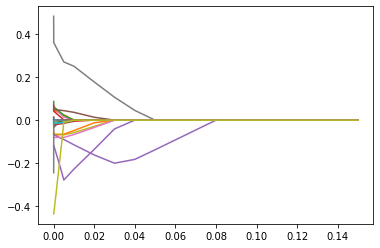

In [ ]:
plt.plot(coef_dataframe)

In [ ]:
coef_dataframe.loc[0.04]


0    -0.000000
1     0.000000
2    -0.000000
3    -0.000000
4    -0.000000
5     0.000000
6     0.000000
7     0.045396
8    -0.000000
9    -0.000000
10   -0.000000
11   -0.000000
12    0.000000
13    0.000000
14   -0.183099
15    0.000000
16   -0.000000
17    0.000000
18   -0.000000
Name: 0.04, dtype: float64

In [ ]:
coef_dataframe.loc[0.03]


0    -0.000000
1     0.000000
2    -0.000000
3    -0.000000
4    -0.040888
5     0.000000
6     0.000000
7     0.106886
8    -0.000000
9    -0.000000
10   -0.000000
11   -0.000000
12    0.000000
13    0.000000
14   -0.200993
15    0.000000
16   -0.000000
17    0.000000
18   -0.000000
Name: 0.03, dtype: float64

In [ ]:
coef_dataframe.loc[0.02]

0    -0.000000
1     0.000000
2    -0.000000
3    -0.000000
4    -0.136289
5    -0.000000
6     0.000000
7     0.178336
8    -0.028809
9    -0.000000
10   -0.000000
11   -0.012241
12    0.000000
13    0.000000
14   -0.162509
15    0.013536
16   -0.034271
17    0.000000
18   -0.000000
Name: 0.02, dtype: float64

In [ ]:
coef_dataframe.loc[0.01]

0     0.000000
1     0.000847
2    -0.000000
3    -0.005107
4    -0.228501
5    -0.000000
6     0.000000
7     0.251737
8    -0.058111
9    -0.000000
10   -0.000000
11   -0.048535
12    0.000000
13    0.000000
14   -0.115069
15    0.036494
16   -0.067216
17    0.000000
18   -0.000000
Name: 0.01, dtype: float64

Para alpha = 0.03 o filtro da regressão forneceu 3 betas diferentes de zero, para alpha = 0.02 temos 7 features e para alpha = 0.01 temos 9 features. Assim, acreditamos que esse seja um bom ponto de corte para realizar os testes, tendo em vista que para valores maiores temos um número muito pequeno de betas e não queremos fazer previsões baseadas em somente uma feature.

## PARA ALPHA = 0.01 COM 9 FEATURES

Vamos testar os modelos de classificação Naive Bayes e KNN

Filtrando as features

In [ ]:
X_train_norm

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
185,0.0,0.0,1.0,0.0,0.013889,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.060970,0.002856
2715,1.0,0.0,0.0,0.0,0.569444,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.065467,0.114735
3825,0.0,0.0,1.0,1.0,0.722222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.006497,0.118794
1807,0.0,0.0,0.0,0.0,0.013889,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.576212,0.008791
132,1.0,0.0,0.0,0.0,0.930556,1.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.318341,0.375380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,1.0,0.0,0.0,0.0,0.097222,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.259370,0.037134
891,1.0,0.0,1.0,1.0,0.694444,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.333333,0.851074,0.577780
2793,1.0,0.0,0.0,0.0,0.055556,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.613693,0.038706
5912,0.0,1.0,0.0,0.0,0.652778,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.664668,0.457046


In [ ]:
X_train_norm_alpha_um = X_train_norm.drop(columns=['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies'])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_norm_alpha_um, Y_treino)

KNeighborsClassifier(n_neighbors=3)

Tratar os dados de validação pra testar o modelo

In [ ]:
X_val["TotalCharges"] = pd.to_numeric(X_val.TotalCharges, errors='coerce')
X_val['TotalCharges'].replace(np.NaN, 0, inplace=True)

# X_val.drop('customerID', axis=1, inplace=True)
X_val.replace('No phone service', 'No', inplace=True)
X_val.replace('No internet service', 'No', inplace=True)
X_val.replace('No', 0, inplace=True)
X_val.replace('Yes', 1, inplace=True)
X_val.replace('Female', 0, inplace=True)
X_val.replace('Male', 1, inplace=True)
X_val.replace('DSL', 1, inplace=True)
X_val.replace('Fiber optic', 2, inplace=True)
X_val.replace('Month-to-month', 0, inplace=True)
X_val.replace('Two year',  2, inplace=True)
X_val.replace('One year', 1, inplace=True)
X_val.replace('Electronic check', 0, inplace=True)
X_val.replace('Bank transfer (automatic)', 1, inplace=True)
X_val.replace('Mailed check', 2, inplace=True)
X_val.replace('Credit card (automatic)', 3, inplace=True)



X_val_norm = X_val.apply(lambda x: normalizar(x), axis = 0)

X_val_norm_alpha_um = X_val_norm.drop(columns=['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies'])

Y_val.replace('Yes', 1, inplace=True)
Y_val.replace('No', 0, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
predict = list(neigh.predict(X_val_norm_alpha_um))
print(predict)

[0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [ ]:
ans = []
Y_val = list(Y_val)

for i in range(len(predict)):
  value = (Y_val[i] == predict[i])
  ans.append(value)
  result_matrix = np.matrix([predict, Y_val, ans])
# print(len(predict))
# print(len(Y_val))
# print(len(ans))
columns = ['Real', 'Predict', 'Result']
result_matrix = pd.DataFrame(result_matrix.T, columns=columns)
print(result_matrix[result_matrix.Result == 1].count())
print(result_matrix[result_matrix.Result == 0].count())


Real       1607
Predict    1607
Result     1607
dtype: int64
Real       506
Predict    506
Result     506
dtype: int64


[0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
